In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

## Data Division & Preprocessing Functions

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for row in range(len(new)-1):
        heading = new.iloc[row,3]
        next_heading = new.iloc[row+1,3]
        if np.abs(next_heading-heading) >= np.pi:
            new.iloc[row+1,3] = new.iloc[row,3]


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/1000

    return np.array(interp)

In [3]:
for me in range(1,18):
    exec(f'me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')

In [4]:
for me in range(1,18):
    exec(f'Lme{me},Rme{me} = divide_data_by_flow_direction(me{me})')

In [5]:
for me in range(1,18):
    exec(f'Lme{me}C_0, Lme{me}C_01, Lme{me}C_1, Lme{me}C_2, Lme{me}C_3, \
        Lme{me}C_5, Lme{me}C_7, Lme{me}C_10 = divide_data_by_contrast(Lme{me})')
    exec(f'Rme{me}C_0, Rme{me}C_01, Rme{me}C_1, Rme{me}C_2, Rme{me}C_3, \
        Rme{me}C_5, Rme{me}C_7, Rme{me}C_10 = divide_data_by_contrast(Rme{me})')

In [6]:
contrasts = ['01','1','2','3','5','7','10']
flows = ['R','L']
for flow in flows:
    for contrast in contrasts:
        for me in range(1,18):
            exec(f'{flow}me{me}C_{contrast} = omr_preprocess({flow}me{me}C_{contrast})')

- for 1 fish for each contrast do R-L --> should be around zero
- AVERAGE THE DIFFERENCES

- time vs cumulative for given contrast for all fish 

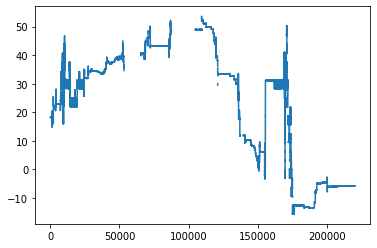

In [7]:
plt.plot(me12["cumulative_direction"])

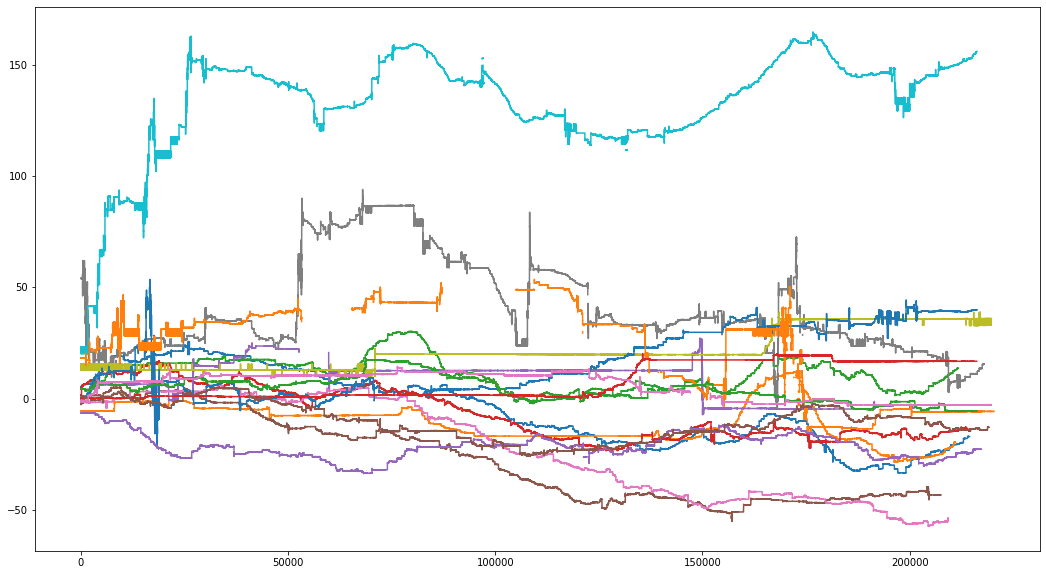

In [8]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
# plt.xlim(0,50000)
for i in range(1,18):
    exec(f'ax.plot(me{i}["cumulative_direction"])')

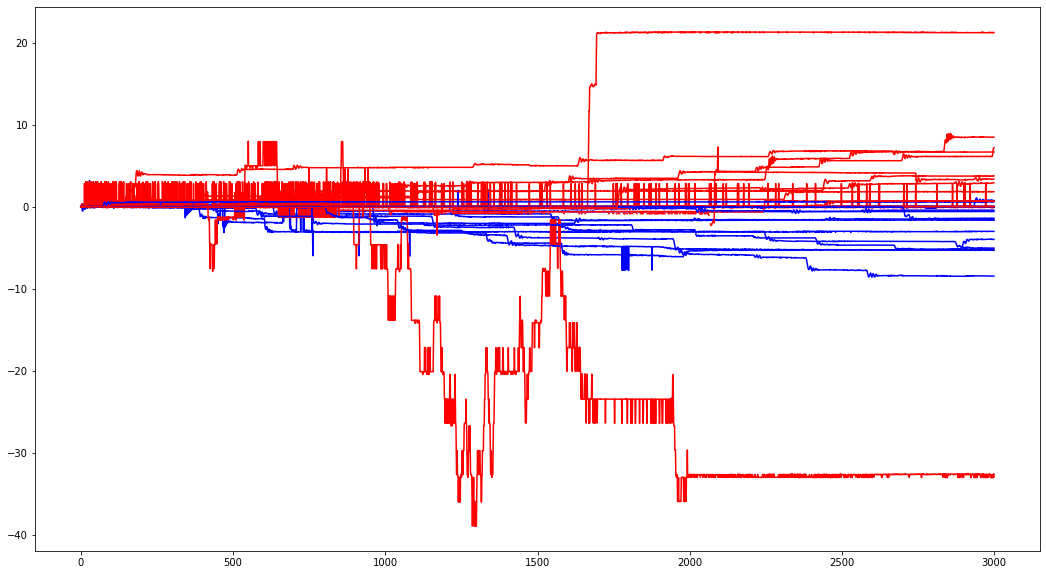

In [9]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
# plt.ylim(-20,25)
for i in range(1,18):
    exec(f'ax.plot(Lme{i}C_10[:,4],c="b")')
    exec(f'ax.plot(Rme{i}C_10[:,4],c="r")')

In [10]:
for contrast in ['01','1','2','3','5','7','10']:
    exec(f'mean_LC{contrast} = np.nanmean(np.array([Lme1C_{contrast}[:,4],Lme2C_{contrast}[:,4],Lme3C_{contrast}[:,4],\
        Lme4C_{contrast}[:,4],Lme5C_{contrast}[:,4],Lme6C_{contrast}[:,4],Lme7C_{contrast}[:,4],\
        Lme8C_{contrast}[:,4],Lme9C_{contrast}[:,4],Lme10C_{contrast}[:,4],Lme11C_{contrast}[:,4],\
        Lme12C_{contrast}[:,4],Lme13C_{contrast}[:,4],Lme14C_{contrast}[:,4],Lme15C_{contrast}[:,4],\
        Lme16C_{contrast}[:,4],Lme17C_{contrast}[:,4]]),axis=0)')

    exec(f'mean_RC{contrast} = np.nanmean(np.array([Rme1C_{contrast}[:,4],Rme2C_{contrast}[:,4],Rme3C_{contrast}[:,4],\
        Rme4C_{contrast}[:,4],Rme5C_{contrast}[:,4],Rme6C_{contrast}[:,4],Rme7C_{contrast}[:,4],\
        Rme9C_{contrast}[:,4],Rme10C_{contrast}[:,4],Rme11C_{contrast}[:,4],Rme13C_{contrast}[:,4],\
        Rme14C_{contrast}[:,4],Rme15C_{contrast}[:,4],Rme16C_{contrast}[:,4],Rme17C_{contrast}[:,4]]),axis=0)')

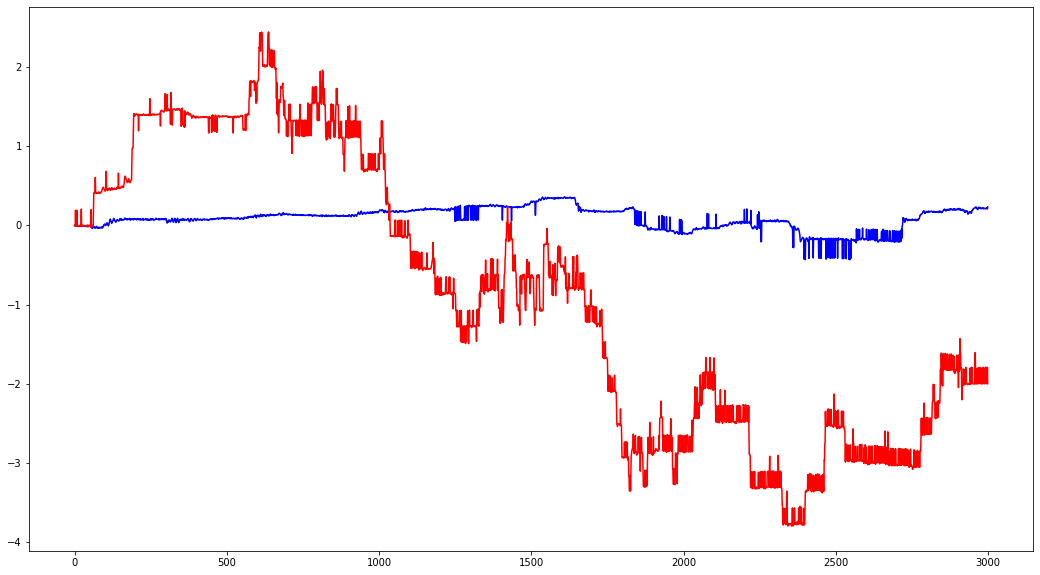

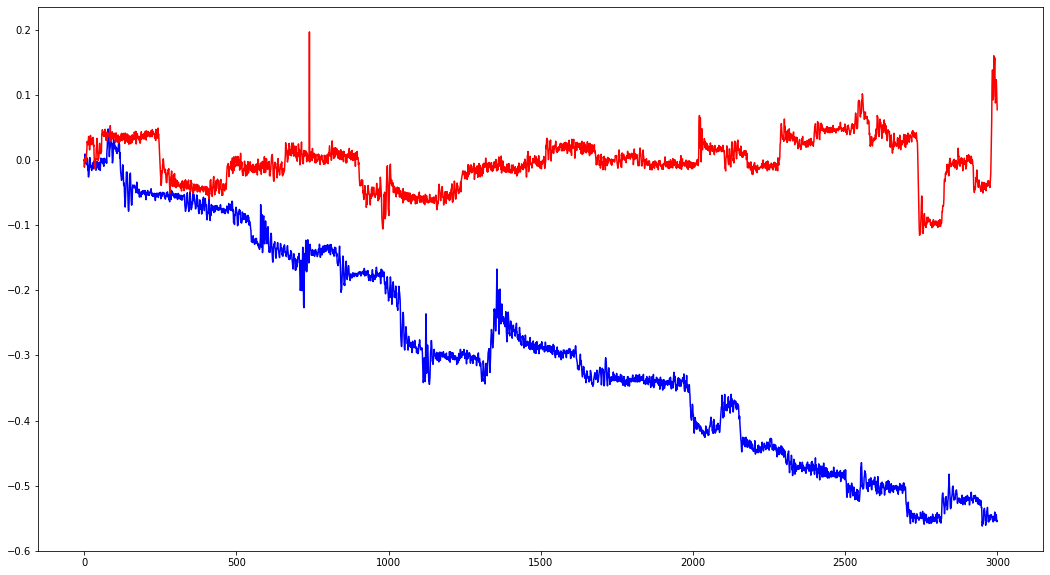

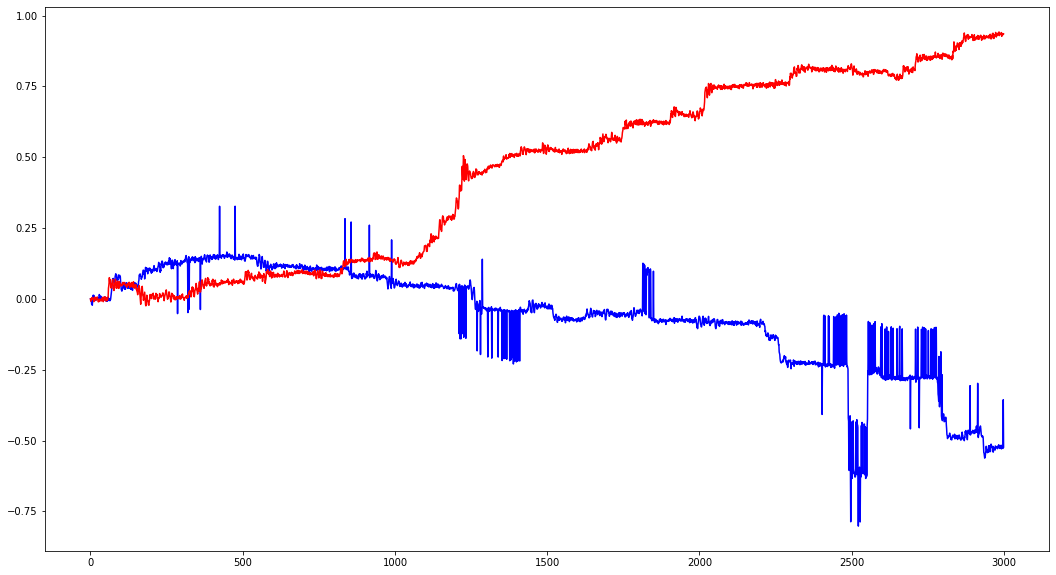

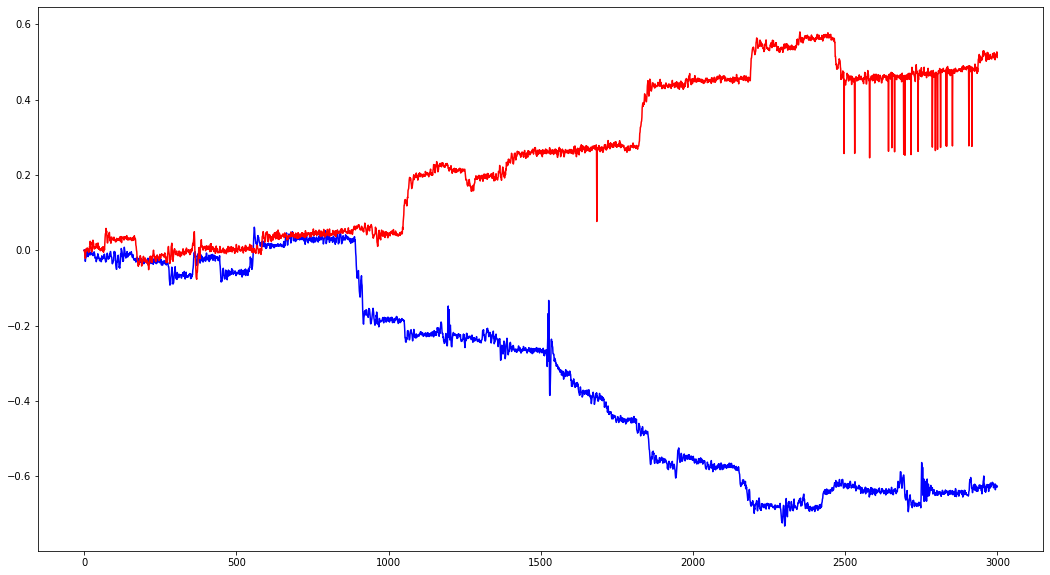

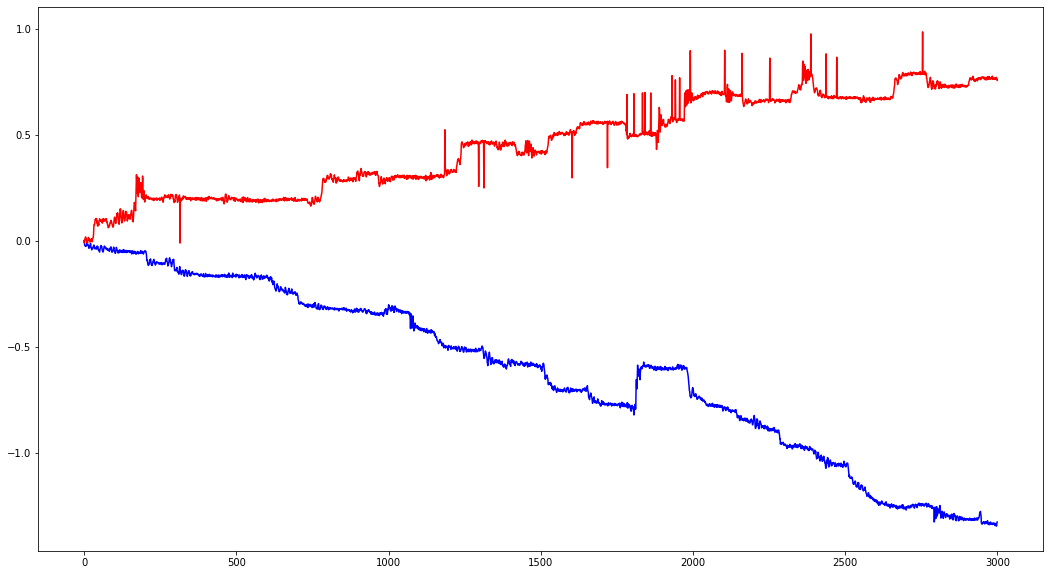

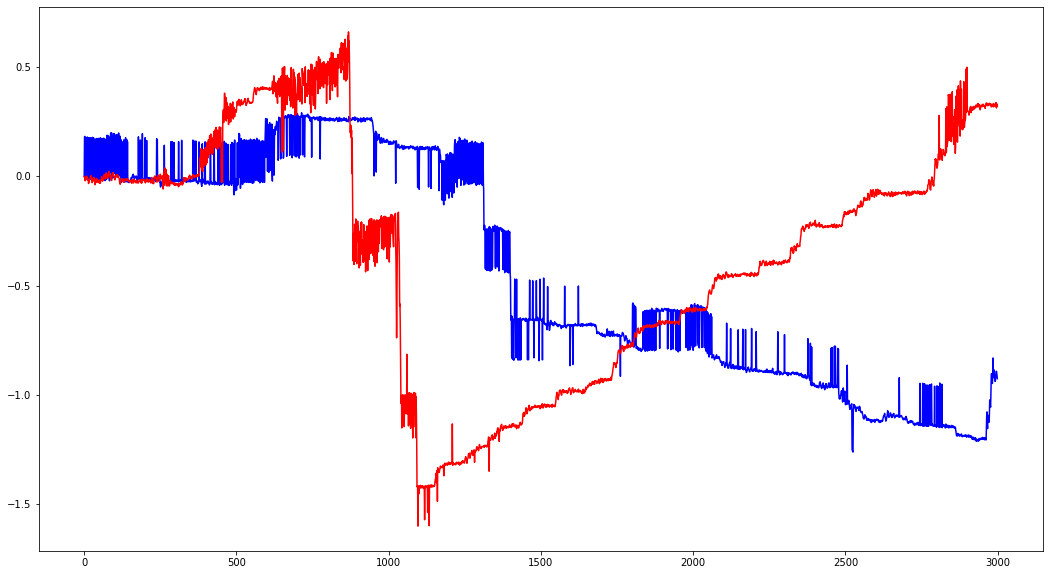

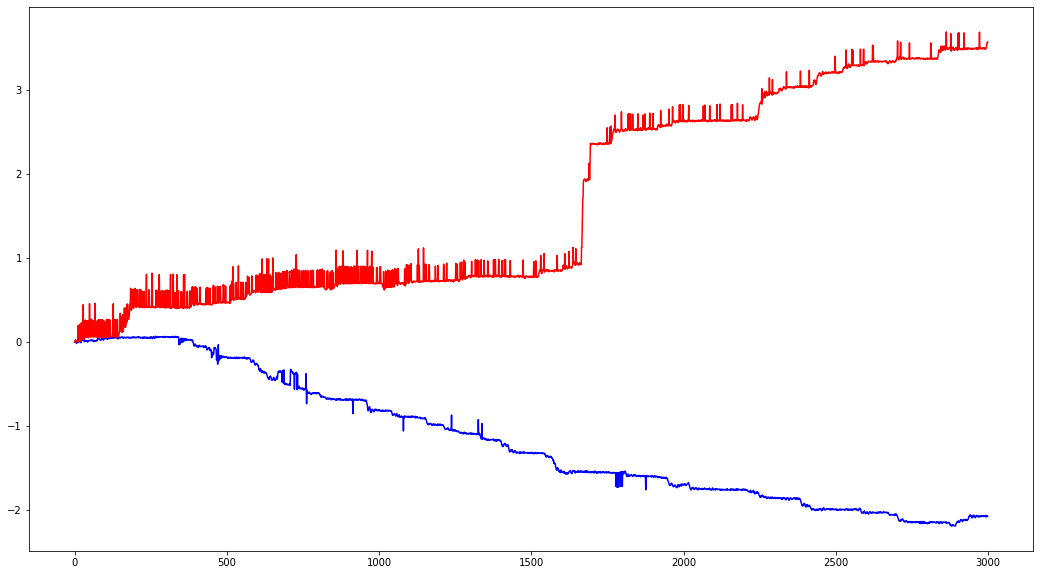

In [11]:
for contrast in ['01','1','2','3','5','7','10']:
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    exec(f"ax.plot(mean_LC{contrast},'b')")
    exec(f"ax.plot(mean_RC{contrast},'r')")

In [12]:
Rme5C_5

array([[1.00000000e-03,            nan,            nan,            nan,
                   nan, 0.00000000e+00],
       [2.00000000e-03,            nan,            nan,            nan,
                   nan,            nan],
       [3.00000000e-03,            nan,            nan,            nan,
                   nan,            nan],
       ...,
       [2.99800000e+00, 6.21744300e+02, 9.05084200e+02, 5.28594199e+00,
                   nan, 6.81241279e-01],
       [2.99900000e+00, 6.22431700e+02, 9.05341000e+02, 5.26362231e+00,
                   nan, 7.33801744e-01],
       [3.00000000e+00, 6.23503300e+02, 9.06438200e+02, 5.26417939e+00,
                   nan, 1.53368002e+00]])

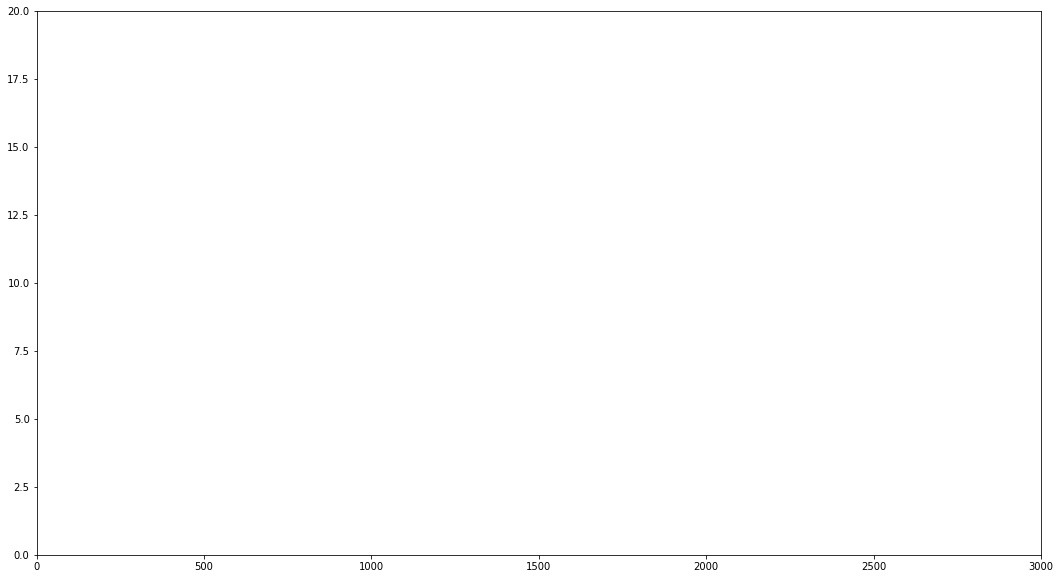

In [13]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.xlim(0,3000)
plt.ylim(0,20)
plt.plot(Rme5C_5[:,4])

(149000.0, 151000.0)

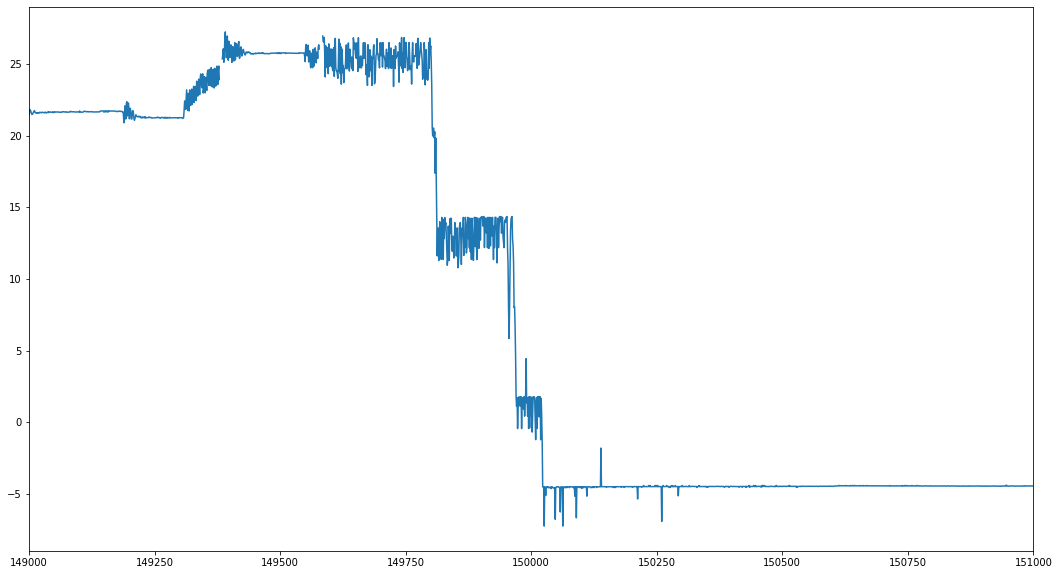

In [14]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(me5['cumulative_direction'])
plt.xlim(149000,151000)

## Stacking all Fish together

In [15]:
def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [17]:
contrasts = ['01','1','2','3','5','7','10']
flows = ['R','L']
for flow in flows:
    for contrast in contrasts:
        exec(f'{flow}ME_C_{contrast} = combine_fish_data({flow}me1C_{contrast},{flow}me2C_{contrast},\
        {flow}me3C_{contrast},{flow}me4C_{contrast},{flow}me5C_{contrast},{flow}me6C_{contrast},\
        {flow}me7C_{contrast},{flow}me8C_{contrast},{flow}me9C_{contrast},{flow}me10C_{contrast},\
        {flow}me11C_{contrast},{flow}me12C_{contrast},{flow}me13C_{contrast},{flow}me14C_{contrast},\
        {flow}me15C_{contrast},{flow}me16C_{contrast},{flow}me17C_{contrast})')

In [18]:
LME_C_01.shape

(17, 3000, 6)

- LME_C_01
- LME_C_1...
- LME_C_10
- RME_C_01
- RME_C_1...
- RME_C_10

## Taking mean of last cumulative heading

In [19]:
LME_C_01_cum_mean = np.nanmean(LME_C_01[:,-1,4])
LME_C_1_cum_mean = np.nanmean(LME_C_1[:,-1,4])
LME_C_2_cum_mean = np.nanmean(LME_C_2[:,-1,4])
LME_C_3_cum_mean = np.nanmean(LME_C_3[:,-1,4])
LME_C_5_cum_mean = np.nanmean(LME_C_5[:,-1,4])
LME_C_7_cum_mean = np.nanmean(LME_C_7[:,-1,4])
LME_C_10_cum_mean = np.nanmean(LME_C_10[:,-1,4])

In [20]:
RME_C_01_cum_mean = np.nanmean(RME_C_01[:,-1,4])
RME_C_1_cum_mean = np.nanmean(RME_C_1[:,-1,4])
RME_C_2_cum_mean = np.nanmean(RME_C_2[:,-1,4])
RME_C_3_cum_mean = np.nanmean(RME_C_3[:,-1,4])
RME_C_5_cum_mean = np.nanmean(RME_C_5[:,-1,4])
RME_C_7_cum_mean = np.nanmean(RME_C_7[:,-1,4])
RME_C_10_cum_mean = np.nanmean(RME_C_10[:,-1,4])

## Plotting mean cumulative heading


<BarContainer object of 7 artists>

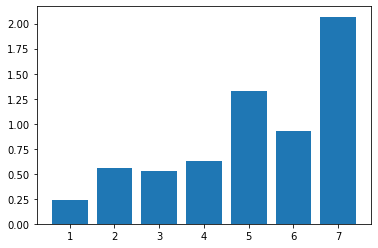

In [21]:
plt.bar([1,2,3,4,5,6,7],[abs(LME_C_01_cum_mean),abs(LME_C_1_cum_mean),abs(LME_C_2_cum_mean),abs(LME_C_3_cum_mean),\
                        abs(LME_C_5_cum_mean),abs(LME_C_7_cum_mean),abs(LME_C_10_cum_mean)])

<BarContainer object of 7 artists>

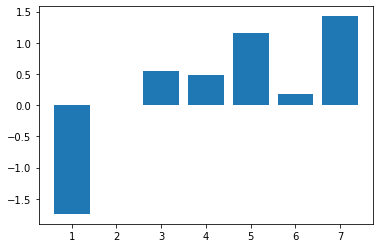

In [22]:
plt.bar([1,2,3,4,5,6,7],[RME_C_01_cum_mean,RME_C_1_cum_mean,RME_C_2_cum_mean,RME_C_3_cum_mean,\
                        RME_C_5_cum_mean,RME_C_7_cum_mean,RME_C_10_cum_mean])

## Gaussian Smoothing of Distance

In [23]:
for fish in combined_fish:
    fish_distance = fish[:,5]
    fish_distance = gaussian_filter1d(fish_distance,sigma=5)
    fish_distance_2 = []
    for frame in fish_distance:
        if frame<=0.1:
            frame=0
        fish_distance_2.append(frame)
    fish_distance = fish_distance_2

NameError: name 'combined_fish' is not defined

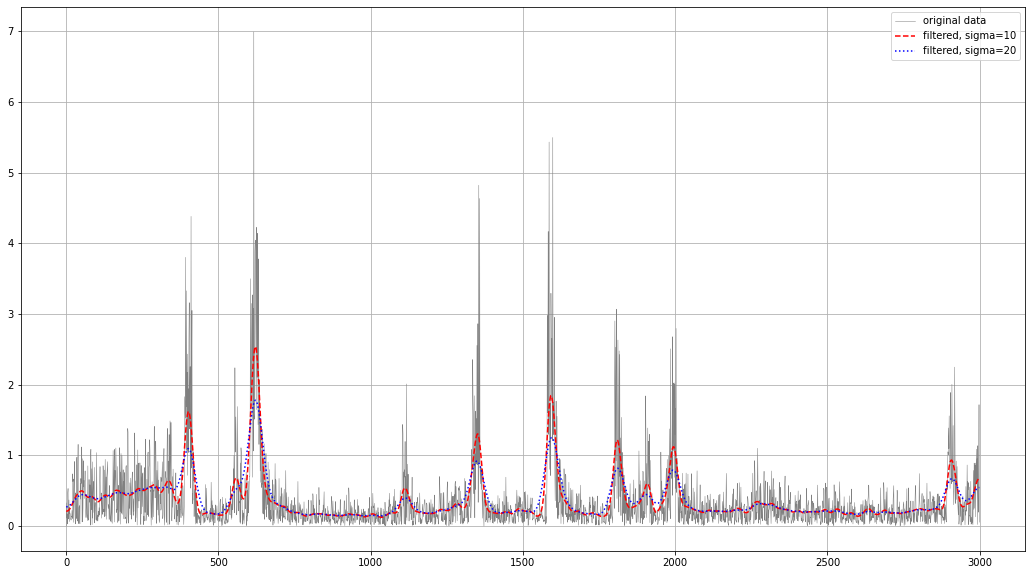

In [24]:
from scipy.ndimage import gaussian_filter1d

original = LME_C_10[2,:,-1]
smooth1 = gaussian_filter1d(LME_C_10[2,:,-1],sigma=10)
smooth2 = gaussian_filter1d(LME_C_10[2,:,-1],sigma=20)

fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.plot(original, 'gray', lw=0.5, label='original data')
ax.plot(smooth1, '--', color='r',label='filtered, sigma=10')
ax.plot(smooth2, ':', color='b',label='filtered, sigma=20')
ax.legend()
ax.grid()
plt.show()

In [25]:
fish_distance = LME_C_10[2,:,-1]
fish_distance = gaussian_filter1d(fish_distance,sigma=20)

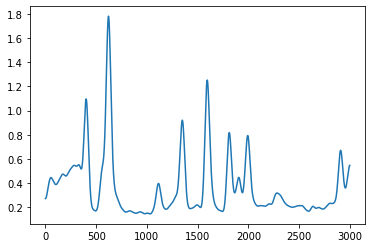

In [26]:
plt.plot(fish_distance)

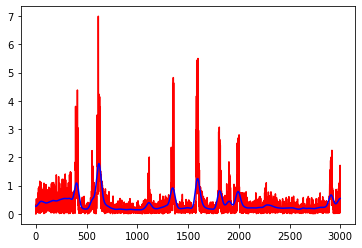

In [27]:
plt.plot(LME_C_10[2,:,-1],'r')
plt.plot(fish_distance,'b')
plt.show()

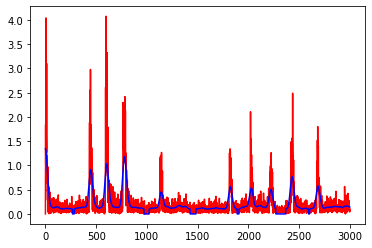

In [28]:
fish_distance = LME_C_10[9,:,-1]
fish_distance_gauss = gaussian_filter1d(fish_distance,sigma=15)

fish_distance_2 = []
for frame in fish_distance_gauss:
    if frame<=0.1:
        frame=0
    fish_distance_2.append(frame)
fish_distance_gauss = fish_distance_2

plt.plot(fish_distance,'r')
plt.plot(fish_distance_gauss,'b')

- preprocess
- threshold
- separate data


0.07091665185530951


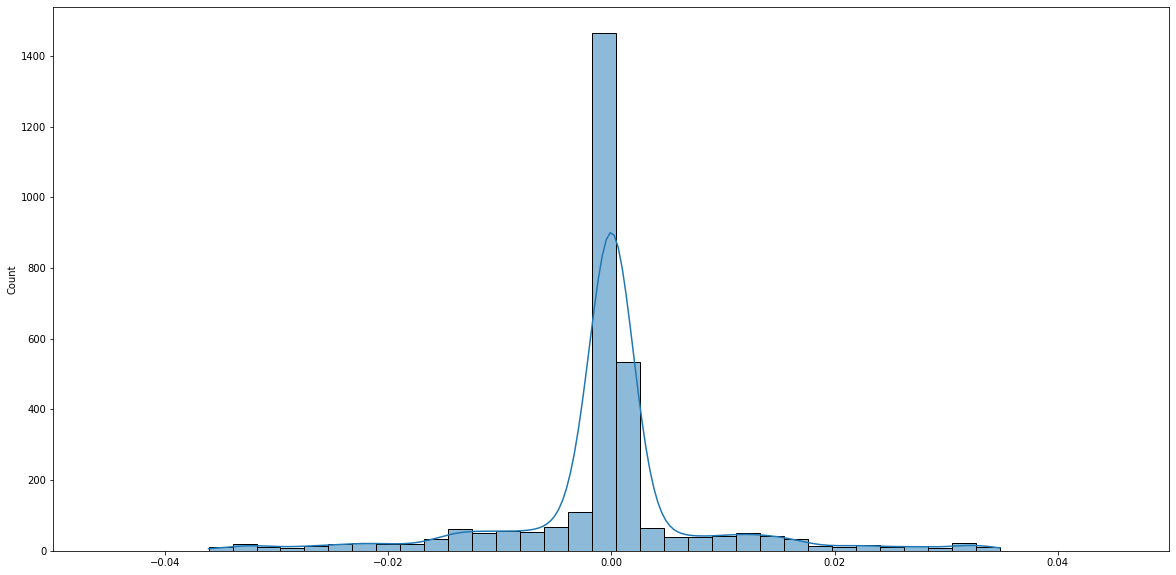

In [32]:
fish_distance = LME_C_10[9,:,5]
fish_distance = gaussian_filter1d(fish_distance,sigma=15)
fish_distance_2 = []
for frame in fish_distance:
    if frame<=0.1:
        frame=0
    fish_distance_2.append(frame)
fish_distance = fish_distance_2

# Differentiating the smoothed distance
derivative = np.gradient(fish_distance,edge_order=1)

# Smoothing the derivative
smooth_derivative = gaussian_filter1d(derivative,sigma=1)

# Creating a histogram of smooth derivative 
hist, bin_edges = np.histogram(smooth_derivative,bins='scott')

print(bin_edges[-1]+abs(bin_edges[0]))
fig, ax = plt.subplots(1,1,figsize=(20,10))
plt.xlim(-0.05,0.05)
sns.histplot(smooth_derivative,bins='scott',kde=True)
# plt.plot(len(bin_edges), y, '--', color='r',linewidth=10)
plt.show()

(array([ 446,  604,  780, 1141, 1822, 2028, 2222, 2430, 2686]), {'peak_heights': array([0.91163623, 1.03775832, 1.1846419 , 0.45236628, 0.55936783,
       0.53240459, 0.5055099 , 0.7716937 , 0.57595392])})


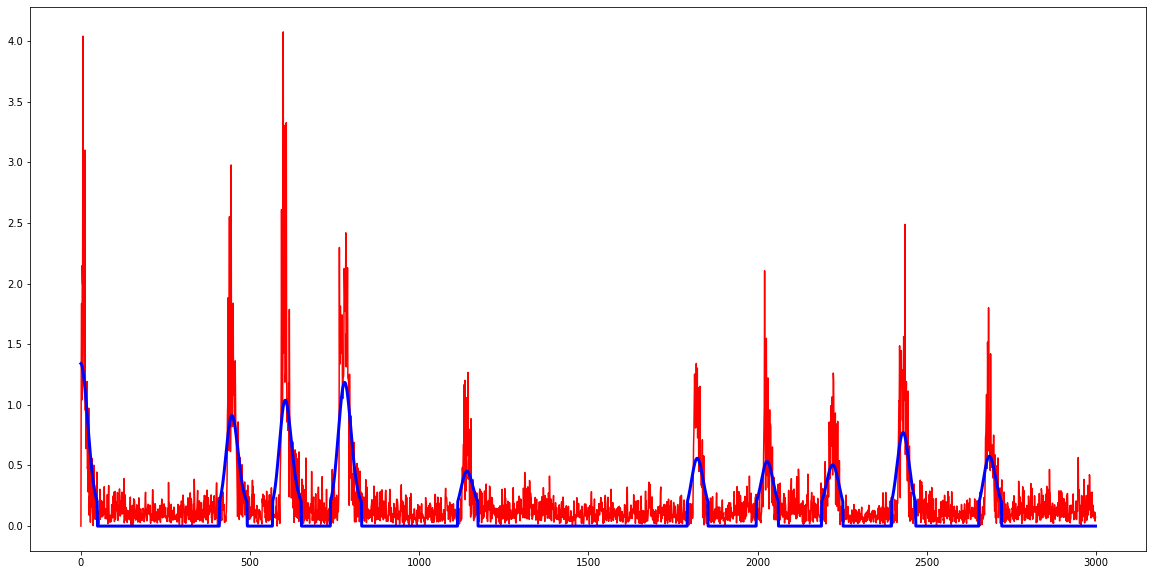

In [30]:
fish_distance = LME_C_10[9,:,-1]
fish_distance_gauss = gaussian_filter1d(fish_distance,sigma=15)

fish_distance_2 = []
for frame in fish_distance_gauss:
    if frame<=0.2:
        frame=0
    fish_distance_2.append(frame)
fish_distance_gauss = fish_distance_2

print(find_peaks(fish_distance_gauss,height=(bin_edges[-1]+abs(bin_edges[0])*2)))

fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(fish_distance,'r')
ax.plot(fish_distance_gauss,'b',lw=3)
plt.show()